Importing libraries

In [112]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np
from sklearn import preprocessing
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

The data is read from the disk. The API "kaggle datasets download -d kemical/kickstarter-projects" may also be used. The "encoding" in the command helps us open the csv file without any problems.

In [113]:
df = pd.read_csv('ks-projects-201801.csv', encoding = "ISO-8859-1")

In [114]:
print("The given table has the following attributes" + str(list(df)))
# Make sure that all the date times are in the proper format in pandas
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])

# # to unix timestamp
df['deadline']=df['deadline'].astype(np.int64)
df['launched']=df['launched'].astype(np.int64)
df['duration']=df['launched']-df['deadline']

The given table has the following attributes['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']


Drop the columns that have values giving away the answer you are setting out to predict, or the values that do not give any necessary addage to the model.

In [115]:
df.drop('ID', axis=1,inplace=True)
df.drop('pledged', axis=1,inplace=True)
df.drop('usd pledged', axis=1,inplace=True)
df.drop('goal', axis=1,inplace=True)
df.drop('usd_pledged_real', axis=1,inplace=True)
df.drop('name', axis=1,inplace=True)
df.drop('deadline', axis=1,inplace=True)
df.drop('launched', axis=1,inplace=True)
df.drop('duration', axis=1,inplace=True)

print("The final model will use the following attributes:" + str(list(df)))

print("The given data has the following unique states:" + str(df.state.unique()))
print("Since the states like 'undefined' and 'suspended' and 'cancelled' provide no value to the classification, we shall remove them.")

The final model will use the following attributes:['category', 'main_category', 'currency', 'state', 'backers', 'country', 'usd_goal_real']
The given data has the following unique states:['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']
Since the states like 'undefined' and 'suspended' and 'cancelled' provide no value to the classification, we shall remove them.


Remove the values that may confuse the classifiers among the available states:

In [116]:
df.drop(df[df.state == 'undefined'].index,inplace=True)
df.drop(df[df.state == 'live'].index,inplace=True)
df.drop(df[df.state == 'suspended'].index,inplace=True)

Converting non-numeric values to numeric ones. We are using the label encoder to achieve this effect. Label encoder labels the non-numeric values with value between 0 and n_classes-1.

In [117]:
le=preprocessing.LabelEncoder()
le.fit(df.category)
df.category=le.transform(df.category) 
# to see the corresponding names from the numeric values, one can use:
# list(le.inverse_transform(le.transform(df.category.unique()) ))

le.fit(df.main_category)
df.main_category=le.transform(df.main_category) 

le.fit(df.currency)
df.currency=le.transform(df.currency)

le.fit(df.country)
df.country=le.transform(df.country)

I am converting the different values seen in the states column to numeric values such that it is either 1- meaning that the project has been successful; or 0- the project has failed/has been canceled.

In [118]:
df['state'] = df['state'].map({'failed' : 0,'canceled' : 0,'successful' : 1})

As I am have a rather slow computer, I am first trying to test the classification pipeline on a small set of values before trying the whole set of values. In the case below, I am useing only the first 10000 values.

In [8]:
df_new=df[:10000]

Here, 'X' represents the set of features and their corresponding values for each project. 'y' is state which tells us whether the project will be a success or failure. We are using the classifier to predict 'y'

In [9]:
y = df_new.state
X = df_new.drop('state', axis=1)

Now, we first randomize the data (or pseudo-randomize!) and try to split the data into training and test sets. The training set will be the data that shall be used to do the fitting. The test set will be used to test if the model is as good as want it to be ;).

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=102)
 
# Then, we write down the data preprocessing steps. The classifier used in this case is the random forest classifier.
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                          RandomForestClassifier(n_estimators=10))
 
# Now we go on to determine the hyperparameters to tune. These are a set of values that you give in so that we can optimize
# the code.
hyperparameters = { 'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestclassifier__max_depth': [None, 5, 3, 1]}
 
# Tune model using cross-validation pipeline. The grid search is very useful in the optimization of the hyper parameters. Other
# methods to fine-tune the hyper parameters such as the Bayesian optimization exist for random forests. I shall try them if I 
# get a chance!
clf = GridSearchCV(pipeline, hyperparameters, cv=10)

# Let the fitting begin! 
clf.fit(X_train, y_train)

# Evaluate model pipeline on test data.
y_pred = clf.predict(X_test)

#Understand the accueracy of the data
randforest_accu = metrics.accuracy_score(y_test,y_pred)

To get the feature that the model most depends on, we can try to understand the plot given below. According to this, the number of backers are the determining feature on which the classification heavily depends. Next, the classification depends on the currency, and thhen on the country. It depends least on the goal amount.

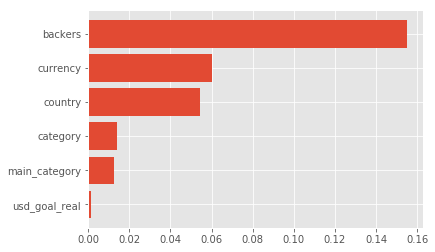

In [82]:
rfc=RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)
def f_importances(coef, names):
    imp = abs(coef[0])
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = list(X)
rfc = LinearSVC()
rfc.fit(X_test,y_test)
f_importances(rfc.coef_, features_names)
y_pred=rfc.predict(X_test)

In [39]:
# Null accuracy for the given data set:
max(y_test.mean(),1-y_test.mean())

0.639

I have used R-squared score (r2) to find how good my model is. The r2 score measures how close the data is to the fitted regression line. A value of 0 indicates that the model explains none of the variability of the response data around its mean.

In [32]:
r2_random_forest = r2_score(y_test, y_pred)
mse_random_forest = mean_squared_error(y_test, y_pred)

#r2 score is around 70%
print(r2_random_forest)
print(mse_random_forest)

0.6466951911530742
0.0815


This plot shows the population of points lying at the correct locations, and the poplulation of points in the incrrect locations. The purple populations represent the smaller and incorrect values predicted by the model, and the red and yellow regions represent the more correct preditions.

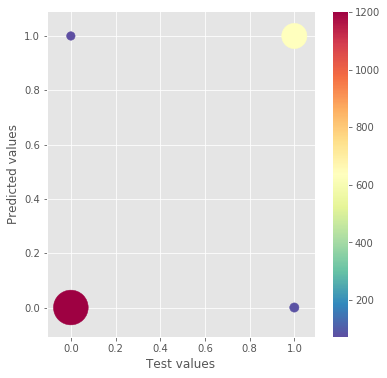

In [86]:
points=list(set(zip(y_test.tolist(),y_pred))) 
count=[len([x for x,y in zip(y_test.tolist(),y_pred) if x==p[0] and y==p[1]]) for p in points]
plot_x=[i[0] for i in points]
plot_y=[i[1] for i in points]
count=np.array(count)
plt.figure(figsize=(6,6))
plt.scatter(plot_x,plot_y,c=count,s=count,cmap='Spectral_r')
plt.xlabel("Test values")
plt.ylabel("Predicted values")
plt.colorbar()
plt.show()

I have used the support vector machine classifier in the linear mode to find the importance of each feature in the data considered. In this case, we learn that  is the most important feature. This importance is calculated using the weights given in the linear svc model

In [88]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
y_pred = linear_svc.predict(X_test)
linear_svc_accu = metrics.accuracy_score(y_test,y_pred)
print(linear_svc_accu)
# Null accuracy
# max(y_test.mean(),1-y_test.mean())
# print(r2_score(y_test, y_pred))
# print(mean_squared_error(y_test, y_pred))

0.903


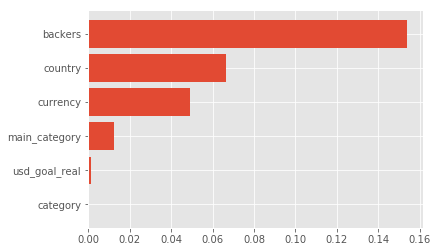

In [90]:
def f_importances(coef, names):
    imp = abs(coef[0])
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = list(X)
svm = LinearSVC()
svm.fit(X_test,y_test)
f_importances(svm.coef_, features_names)
y_pred=svm.predict(X_test)

In [91]:
#Learning feature importance of linear SVM kernel, because non-linear is not possible. And since the SVC is giving an accuracy 
#of 100%, which seems absurd. 
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
svc_accu = metrics.accuracy_score(y_test,y_pred)
print(svc_accu)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg_accu = metrics.accuracy_score(y_test,y_pred)
print(logreg_accu)

0.6635
0.9025


In [92]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_accu = metrics.accuracy_score(y_test,y_pred)
print(knn_accu)

0.8805


In [93]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test)
gnv_accu = metrics.accuracy_score(y_test,y_pred)
print(gnv_accu)

0.7555


In [95]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
dtree_accu = metrics.accuracy_score(y_test,y_pred)
print(dtree_accu)

0.89


In [98]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
sgd_accu = metrics.accuracy_score(y_test,y_pred)
print(sgd_accu)

0.7345


C:\Users\C5269612\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [99]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Stochastic Gradient Decent', 
              'Linear SVC', 'Decision Tree'],
    'Score': [svc_accu,knn_accu, logreg_accu,
              randforest_accu, gnv_accu, sgd_accu, 
              linear_svc_accu, dtree_accu]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,0.9215
6,Linear SVC,0.9030
2,Logistic Regression,0.9025
1,KNN,0.8805
4,Naive Bayes,0.7555
5,Stochastic Gradient Decent,0.7345
7,Decision Tree,0.6670
0,Support Vector Machines,0.6635


In [140]:
df.corrwith(df.state, axis=0, drop=False)

category         0.023332
main_category   -0.031571
currency         0.064819
state            1.000000
backers          0.129141
country          0.060703
usd_goal_real   -0.023709
dtype: float64

In [126]:
df.groupby(['state','backers']).sum()

category  main_category  currency  country  usd_goal_real
state backers                                                           
0     0         3862087         396654    537997   927630   4.714318e+09
      1         2610416         261310    361811   623269   2.927539e+09
      2         1753857         172724    241748   416095   1.860920e+09
      3         1208328         116626    167943   288457   7.898600e+08
      4          902766          85625    124839   214382   6.419460e+08
      5          717945          67198     98251   168564   6.354029e+08
      6          594794          55100     80845   138744   3.401444e+08
      7          501598          45821     68201   117051   2.744572e+08
      8          433262          39504     57883    99337   2.137272e+08
      9          369838          34127     50416    86466   1.150685e+08
      10         326444          30126     44477    76324   1.198360e+08
      11         279487          25716     38026    65181   8.753691e+07
      12         258538          24004     35772    61240   8.984265e+07
      13         241785          22141     33029    56576   7.731921e+07
      14         221637          20765     29900    51316   7.748401e+07
      15         202218          18139     27546    47155   1.096040e+08
      16         181400          16131     24095    41364   6.234399e+07
      17         178556          16208     23887    40848   6.544308e+07
      18         151303          13403     20402    34938   4.607619e+07
      19         142636          13041     19582    33577   4.603883e+07
      20         134901          12566     18887    32278   4.069806e+07
      21         125303          11266     16717    28725   3.866381e+07
      22         113374          10319     15543    26677   5.011709e+07
      23         110883           9737     14634    25056   2.988437e+07
      24         104678           9200     13913    23797   4.280703e+07
      25         104715           9319     13788    23634   7.986426e+07
      26          98142           8793     12958    22168   6.339377e+07
      27          92308           8419     12186    20865   1.546123e+08
      28          83703           7516     10954    18840   2.914066e+07
      29          80336           7075     10421    17897   3.171724e+07
...                 ...            ...       ...      ...            ...
1     36863         113              4        13       22   1.000000e+04
      39560          67             13        13       22   5.000000e+04
      40642         136              8        13       22   1.000000e+05
      41733         148              8        13       22   2.500000e+05
      42713         148              8        13       22   5.000000e+05
      43733         136              8        13       22   4.000000e+04
      44162         148              8        13       22   9.000000e+05
      44949         113              4        13       22   2.000000e+04
      46520          93              6        13       22   2.000000e+06
      48270         139              6        13       22   2.000000e+06
      61290         148              8        13       22   9.000000e+05
      62642         113              4        13       22   5.000000e+04
      63416          63              8        13       22   9.500000e+05
      63758         136              8        13       22   1.000000e+04
      64867         148              8        13       22   5.000000e+05
      66673         113              4        13       22   1.000000e+06
      67226         148              8        13       22   9.000000e+05
      68929         113              4        13       22   1.000000e+05
      69320         148              8        13       22   2.000000e+06
      70122         138             13         1        3   9.199632e+04
      73206         148              8         5        9   2.771706e+05
      73986         148              8        13       22   1.100000e+06


In [124]:
df.head()

,category,main_category,currency,state,backers,country,usd_goal_real
0,108,12,5,0,0,9,1533.95
1,93,6,13,0,15,22,30000.00
2,93,6,13,0,3,22,45000.00
3,90,10,13,0,1,22,5000.00
4,55,6,13,0,14,22,19500.00
